In [1]:
# This is only needed if the notebook is run in VSCode
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

In [2]:
import sys
sys.path.append('..')
import sklearn
from tsai.basics import *
from swdf.utils import *
my_setup(sklearn)
from matplotlib import dates as mdates
import wandb
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from itertools import chain
import more_itertools as mit

os              : Linux-6.8.0-39-generic-x86_64-with-glibc2.31
python          : 3.10.12
tsai            : 0.3.10
fastai          : 2.7.15
fastcore        : 1.5.49
sklearn         : 1.5.1
torch           : 2.2.2+cu121
device          : 1 gpu (['NVIDIA GeForce RTX 3070 Ti Laptop GPU'])
cpu cores       : 14
threads per cpu : 1
RAM             : 15.28 GB
GPU memory      : [8.0] GB


In [3]:
# This is only needed for the MIT supercloud, to fix fastai's LRFinder error 
if torch.cuda.is_available() and torch.cuda.device_count() == 0:
    from fastai.callback.schedule import LRFinder

    @patch_to(LRFinder)
    def after_fit(self):
        self.learn.opt.zero_grad() # Needed before detaching the optimizer for future fits
        tmp_f = self.path/self.model_dir/self.tmp_p/'_tmp.pth'
        if tmp_f.exists():
            self.learn.load(f'{self.tmp_p}/_tmp', with_opt=True, device='cpu')
            self.tmp_d.cleanup()

# Forecasting solar drivers F10, S10, M10 and Y10

Some hints about hyperparameters:
- According to the authors of PatchTST: "The ideal patch length may depend on the dataset, 
but P between {8, 16} seems to be general good numbers."

In [4]:
config_base = yaml2dict('./config/base.yaml', attrdict=True)
config_solfsmy = yaml2dict('./config/solfsmy.yaml', attrdict=True)
config_train = config_solfsmy.train
config_data = config_solfsmy.data 

# Merge the two configs (the second one overrides the first one for any keys that are present in both)
config = AttrDict({**config_base,
                   **config_train, 
                   "data":AttrDict({**config_data})})

# Add the architecture config
if config.arch_name.lower() == 'patchtst':
    config.arch = yaml2dict('./config/patchtst.yaml', attrdict=True)
else:
    config.arch = AttrDict()

In [5]:
run = wandb.init(project=config.wandb.project, 
                 config=config,
                 group=config.wandb.group,
                 mode=config.wandb.mode, 
                 anonymous='never') if config.wandb.enabled else None
config = dict2attrdict(run.config) if config.wandb.enabled else config

In [6]:
config

```json
{ 'arch': {'attn_dropout': 0.4, 'd_model': 1024, 'dropout': 0.2, 'n_heads': 32},
  'arch_config_file': 'config/patchtst.yaml',
  'arch_name': 'PatchTST',
  'bs': 32,
  'data': { 'add_time_channels': False,
            'data_columns': ['F10', 'S10', 'M10', 'Y10'],
            'data_nb': './solfsmy_data.ipynb',
            'data_path': '../data/SOLFSMY.TXT',
            'data_time_columns': ['Year', 'DDD'],
            'data_url': 'https://sol.spacenvironment.net/JB2008/indices/SOLFSMY.TXT',
            'df_save_path': './preprocessed_data/dataframes/solfsmy.pkl',
            'force_download': False,
            'preproc_pipe_save_path': './preprocessed_data/pipelines/preproc_solfsmy.pkl'},
  'deltaHL': 4.0,
  'horizon': 6,
  'init_weights': False,
  'is_optuna_study': False,
  'lookback': 36,
  'lr_max': None,
  'n_epoch': 50,
  'partial_n': 0.1,
  'seed': 42,
  'test_end_datetime': '2018-12-31 12:00:00',
  'test_start_datetime': '2012-10-01 12:00:00',
  'valid_start_datetime': '2018-01-01 12:00:00',
  'wandb': { 'enabled': False,
             'group': None,
             'log_learner': True,
             'mode': 'offline',
             'project': 'swdf'}}
```

In [7]:
df, preproc_pipe = generate_preprocessed_data(config.data)

df.head()

,Year,DDD,JulianDay,F10,F81c,S10,S81c,M10,M81c,Y10,Y81c,Ssrc,Ssrc_F10,Ssrc_S10,Ssrc_M10,Ssrc_Y10,Date
0,1997,1,2450450.0,72.400002,78.000000,74.000000,79.199997,65.400002,73.800003,61.900002,70.699997,1B11,1,B,1,1,1997-01-01 12:00:00
1,1997,2,2450451.0,72.099998,77.900002,73.800003,79.099998,66.900002,73.699997,63.400002,70.400002,1B11,1,B,1,1,1997-01-02 12:00:00
2,1997,3,2450452.0,73.300003,77.599998,75.000000,79.099998,70.099998,73.599998,64.900002,70.199997,1B11,1,B,1,1,1997-01-03 12:00:00
3,1997,4,2450453.0,73.800003,77.300003,76.300003,79.000000,71.599998,73.400002,65.500000,69.800003,1B11,1,B,1,1,1997-01-04 12:00:00
4,1997,5,2450454.0,74.400002,76.900002,77.599998,78.900002,72.400002,73.300003,66.699997,69.599998,1B11,1,B,1,1,1997-01-05 12:00:00


## Train

In the paper by [Licata et al. (2020)]((https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2020SW002496)), authors use a period from October 2012 through the end of 2018 for the benchmarking. Therefore, we will set the test set as the same period for our analysis, using the column Date as the timestamp, from October 2012 to the end of 2018. Everything before the test set will be used for training, and everything after the test set will be used for validation. In this paper, the authors also present some the thresholds for categorizing solar activity levels.

In [8]:
test_start_datetime = config.test_start_datetime
test_end_datetime = config.test_end_datetime

thresholds = {
    'F10': [(0,75), (76,150), (151,190), (191, np.inf)],
    'S10': [(0,65), (66,150), (151,215), (216, np.inf)],
    'M10': [(0,72), (73,144), (145,167), (168, np.inf)],
    'Y10': [(0,81), (82,148), (149,165), (166, np.inf)]
}

solact_levels = {
    'F10': ['low', 'moderate', 'elevated', 'high'] ,
    'S10': ['low', 'moderate', 'elevated', 'high'] ,
    'M10': ['low', 'moderate', 'elevated', 'high'] ,
    'Y10': ['low', 'moderate', 'elevated', 'high'] 
}

dict2yaml(thresholds, "distributions/thresholds.yaml")

In [9]:
df_F10 = load_object("./preprocessed_data/dataframes/F10_historical.pkl")

df_F107_cat = get_classified_columns(df_F10, thresholds, activity_levels={'F10': solact_levels['F10']})['F10_Cat']
historical_distribution = df_F107_cat.value_counts(normalize=True).to_dict()

historical_distribution

{'moderate': 0.5065749000307598,
 'low': 0.18390495232236234,
 'high': 0.16145032297754536,
 'elevated': 0.14806982466933252}

In [10]:
test_period = (df.Date >= test_start_datetime) & (df.Date <= test_end_datetime)

df_cat = get_classified_columns(df, thresholds, solact_levels)
df_cat = df_cat[~(test_period)]

# Function parameter calculation
test_size = df[test_period].shape[0] / df.shape[0]
train_val_size = 1 - test_size
val_size = 0.15 / train_val_size
print(f"Test size: {test_size}, Validation size: {val_size}, Train size: {1 - test_size - 0.15}")

# Best segment size found: 250, val_size: 0.15, test_size: 0.65
best_comb, segments, distribution = find_closest_distribution(df_cat['F10_Cat'], historical_distribution, 250, val_size) 

Test size: 0.22903290529695025, Validation size: 0.19456083279115158, Train size: 0.6209670947030498
Total number of segments:30, Number of segments for validation: 5 (16.67%)


6685it [00:00, 66845.92it/s]

142506it [00:02, 70562.07it/s]

The closest group of segments to F10.7 categories has an euclidean distance of 0.005517135807631744


In [11]:
save_object(best_comb, "tmp/data/best_comb.pkl")
save_object(segments, "tmp/data/segments.pkl")

tmp/data directory already exists.
tuple saved as tmp/data/best_comb.pkl
tmp/data directory already exists.
list saved as tmp/data/segments.pkl


In [12]:
best_comb_idxs = [segments[i] for i in best_comb]
validation_segments = (df.index.isin(chain.from_iterable(best_comb_idxs)))

train_df = df[~validation_segments & ~test_period] 
train_distribution = get_classified_columns(train_df, thresholds, solact_levels)['F10_Cat'].value_counts(normalize=True).to_dict()

train_distribution

{'moderate': 0.5067145534041224,
 'low': 0.28856964397251716,
 'elevated': 0.1316364772017489,
 'high': 0.0730793254216115}

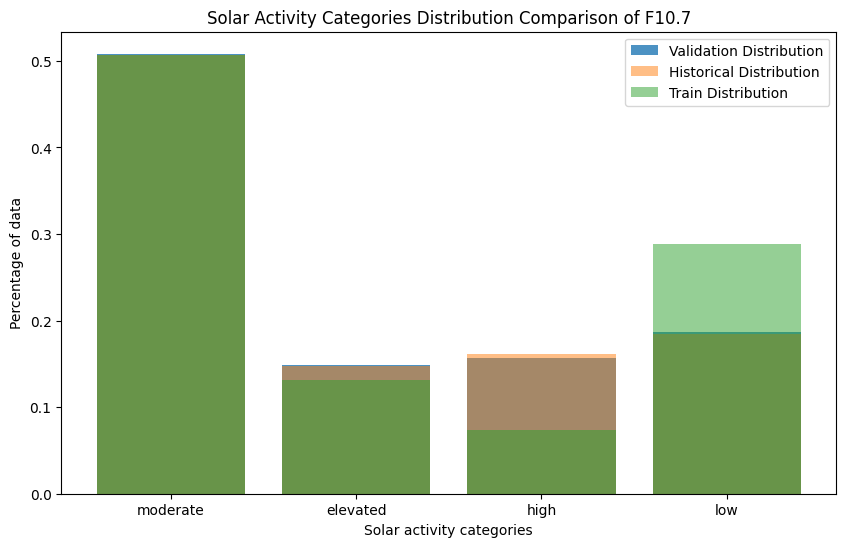

In [13]:
#|hide
# Plot of the distribution found
plt.figure(figsize=(10, 6))
plt.bar(distribution.keys(), distribution.values(), alpha=0.8, label='Validation Distribution')
plt.bar(historical_distribution.keys(), historical_distribution.values(), alpha=0.5, label='Historical Distribution')
plt.bar(train_distribution.keys(), train_distribution.values(), alpha=0.5, label='Train Distribution')

plt.xlabel('Solar activity categories')
plt.ylabel('Percentage of data')
plt.title('Solar Activity Categories Distribution Comparison of F10.7')
plt.legend()
plt.show()

In [14]:
validation = df.loc[chain.from_iterable(best_comb_idxs)]

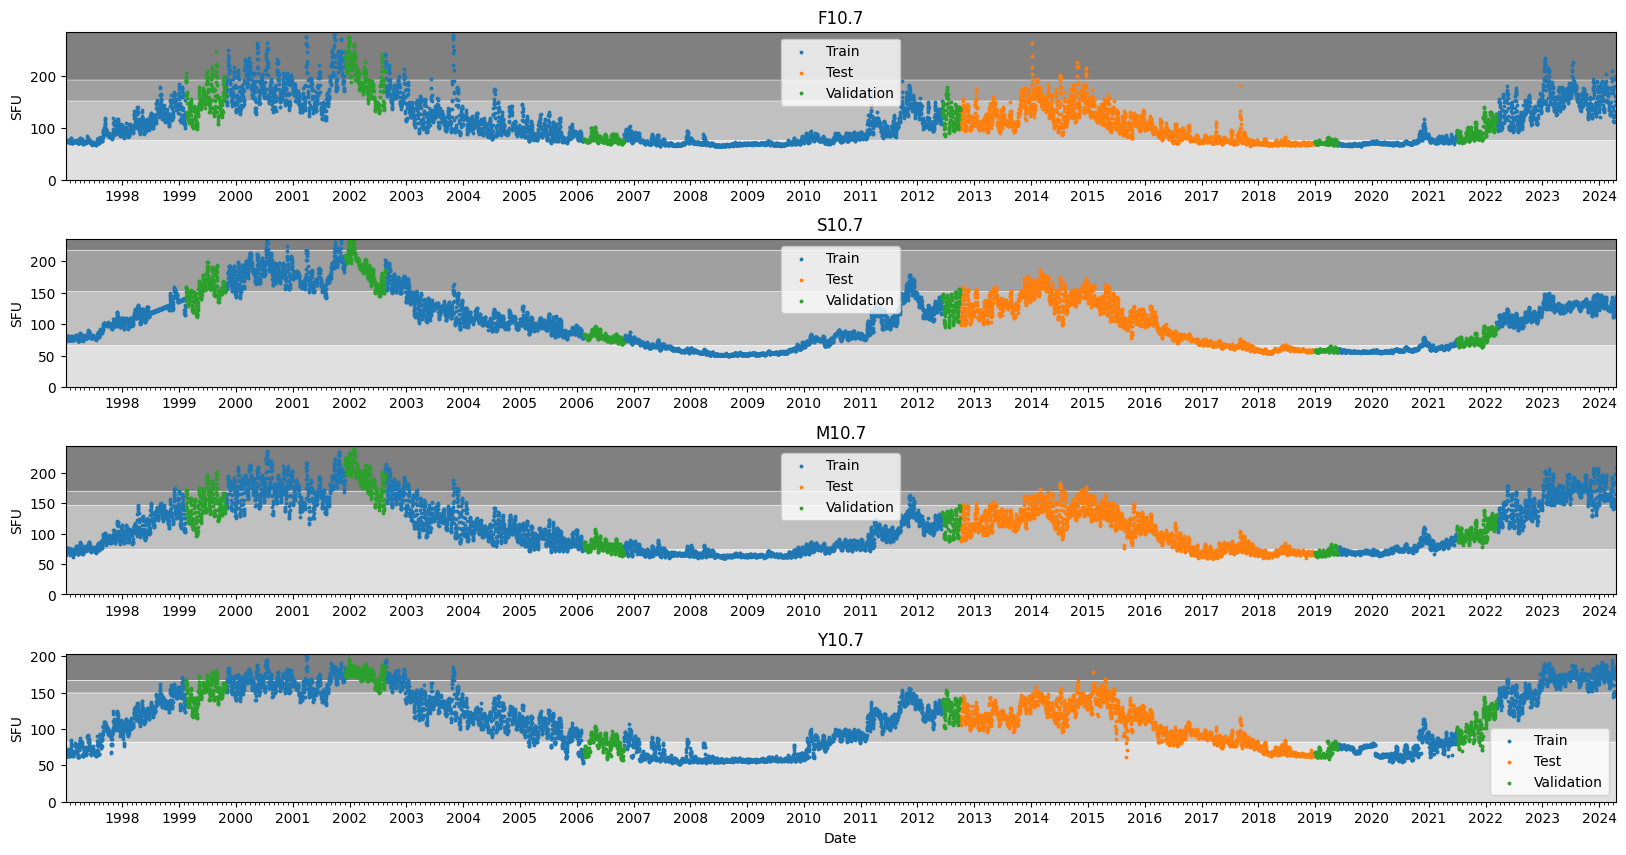

In [15]:
from matplotlib import patches as mpatches
fig, ax = plt.subplots(4, 1, figsize=(20, 10))
plt.subplots_adjust(hspace=0.4)

var_name = ['F10.7', 'S10.7', 'M10.7', 'Y10.7']

for i, var in enumerate(['F10', 'S10', 'M10', 'Y10']):
    ax[i].scatter(train_df.Date, train_df[var], label='Train', s=3)  # s parameter sets the size of the points
    ax[i].scatter(df.Date[(df.Date >= test_start_datetime) & (df.Date <= test_end_datetime)],
                  df[var][(df.Date >= test_start_datetime) & (df.Date <= test_end_datetime)],
                  label='Test', s=3)
    ax[i].scatter(validation.Date,
                  validation[var],
                  label='Validation', s=3)
    ax[i].set_title(var_name[i])
    ax[i].set_ylabel('SFU')  # Add y-axis label with SFU
    ax[i].legend()

    # Format x-axis to show only the years
    ax[i].xaxis.set_major_locator(mdates.YearLocator())
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax[i].xaxis.set_minor_locator(mdates.MonthLocator())  # optional, for minor ticks

    # Ensure all years are shown on the x-axis
    ax[i].set_xlim([df.Date.min(), df.Date.max()])

    set_ranges = np.zeros((int(df[var].max()), df.shape[0], 4))  # (Height, Width)

    for j, (start, end) in enumerate(thresholds[var]):
        if end == np.inf:
            end = 9999
        set_ranges[int(start):int(end), :, :] = [0, 0, 0, ((j + 1) / 4)]
   
    ax[i].imshow(set_ranges, extent=[df.Date.min(), df.Date.max(), 0, df[var].max()], aspect='auto', alpha=0.5, origin='lower')

# Optionally, you can set a common x-axis label for all subplots if desired
plt.xlabel('Date')
plt.show()

In [16]:
a = np.arange(0,len(segments))
train_comb = list(np.setdiff1d(a, best_comb))
data_columns = config.data.data_columns

X_val, y_val, split_val = sliding_window_generator(df, 0, data_columns=data_columns, config=config, comb=best_comb, segments=segments)
X_train, y_train, split_train = sliding_window_generator(df, split_val[-1]+1, data_columns=data_columns, config=config, comb=train_comb, segments=segments)
X_test, y_test, split_test = sliding_window_generator(df[test_period], split_train[-1]+1, data_columns=data_columns, config=config) 

X = np.concatenate([X_val, X_train, X_test])
y = np.concatenate([y_val, y_train, y_test])

splits = (split_train, split_val, split_test)
splits, X.shape, y.shape

(((#6158) [1076,1077,1078,1079,1080,1081,1082,1083,1084,1085...],
  (#1076) [0,1,2,3,4,5,6,7,8,9...],
  (#2242) [7234,7235,7236,7237,7238,7239,7240,7241,7242,7243...]),
 (9476, 4, 36),
 (9476, 4, 6))

In [17]:
# Now that we have defined the splits for this particular experiment, we'll scale
# the data
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=data_columns)),
], verbose=True)

df_scaled = exp_pipe.fit_transform(df.copy())

save_object(exp_pipe, 'tmp/pipes/exp_pipe.pkl')
df.head()

[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s
tmp/pipes directory already exists.
Pipeline saved as tmp/pipes/exp_pipe.pkl


,Year,DDD,JulianDay,F10,F81c,S10,S81c,M10,M81c,Y10,Y81c,Ssrc,Ssrc_F10,Ssrc_S10,Ssrc_M10,Ssrc_Y10,Date
0,1997,1,2450450.0,72.400002,78.000000,74.000000,79.199997,65.400002,73.800003,61.900002,70.699997,1B11,1,B,1,1,1997-01-01 12:00:00
1,1997,2,2450451.0,72.099998,77.900002,73.800003,79.099998,66.900002,73.699997,63.400002,70.400002,1B11,1,B,1,1,1997-01-02 12:00:00
2,1997,3,2450452.0,73.300003,77.599998,75.000000,79.099998,70.099998,73.599998,64.900002,70.199997,1B11,1,B,1,1,1997-01-03 12:00:00
3,1997,4,2450453.0,73.800003,77.300003,76.300003,79.000000,71.599998,73.400002,65.500000,69.800003,1B11,1,B,1,1,1997-01-04 12:00:00
4,1997,5,2450454.0,74.400002,76.900002,77.599998,78.900002,72.400002,73.300003,66.699997,69.599998,1B11,1,B,1,1,1997-01-05 12:00:00


 ### Apply a sliding window. 

### Train

In [18]:
weights = {k: np.abs(train_distribution.get(k, 0) - historical_distribution.get(k, 0)) for k in set(train_distribution) | set(historical_distribution)}
factor = 1.0/sum(weights.values())
weights_raw = {k: v*factor for k, v in weights.items()}

weights = {'All': [weights_raw[k] for k in solact_levels['F10']]}
weights, weights_raw

({'All': [0.49933374244488,
   0.0006662575551199645,
   0.07840012484165651,
   0.4215998751583436]},
 {'moderate': 0.0006662575551199645,
  'low': 0.49933374244488,
  'elevated': 0.07840012484165651,
  'high': 0.4215998751583436})

In [19]:
save_object(weights, "tmp/loss_param/solfsmy_weights.pkl")

tmp/loss_param directory already exists.
dict saved as tmp/loss_param/solfsmy_weights.pkl


In [ ]:
from swdf.losses import *

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loss = wMSELoss(thresholds, weights).to(device)
metrics = LossMetrics(loss, solact_levels['F10']).get_metrics()

wandb_callback = WandbCallback(log_preds=False)
cbs = L(wandb_callback) if config.wandb.enabled else L()
learn = TSForecaster(X, y, splits=splits, batch_size=config.bs,
                     pipelines=[preproc_pipe, exp_pipe], 
                     arch=config.arch_name, 
                     metrics=metrics,
                     loss_func=loss,
                     arch_config=dict(config.arch), 
                     init=config.init_weights,
                     cbs= cbs + ShowGraphCallback(), 
                     partial_n=config.partial_n)
lr_max = learn.lr_find().valley if config.lr_max is None else config.lr_max

learn.fit_one_cycle(n_epoch=config.n_epoch, lr_max=config.lr_max)


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

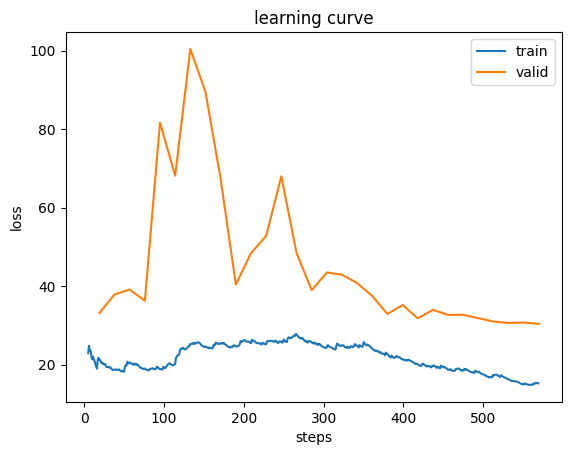

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# Print the validation loss and save it in case other notebooks (optuna) wants to
# use it for hyperparameter optimization
valid_loss = learn.validate()[0]

print(valid_loss)
%store valid_loss

30.369739532470703
Stored 'valid_loss' (float)


In [ ]:
# Save everything
learn.dls.loaders += [learn.dls.valid.new_dl(X[splits[2]], y[splits[2]])] # Add test datalaoder
# Remove the wandb callback to avoid errors when downloading the learner
if config.wandb.enabled:
    learn.remove_cb(wandb_callback)

In [ ]:
best_valid_loss = np.inf
%store -r best_valid_loss

save_all_or_best = (config.is_optuna_study and valid_loss < best_valid_loss) or not config.is_optuna_study

if save_all_or_best:
    best_valid_loss = valid_loss
    %store best_valid_loss                                             

    # Save locally and in wandb if online and enabled
    learn.save_all(path='tmp', verbose=True) 
    if run is not None and config.wandb_mode and config.wandb_log_learner:
        # Save the learner (all tmp/dls, tmp/model.pth, and tmp/learner.pkl). 
        run.log_artifact('tmp', type='learner', name='solfsmy')
    
    # Save the best model
    model = {}
    model['models'] = [learn.model]
    model['lookback'] = config.lookback
    model['horizon'] = config.horizon
    model['data_columns'] = data_columns
    model['thresholds'] = thresholds

    torch.save(model, 'models/best_model.pth')

Stored 'best_valid_loss' (float)
Learner saved:
path          = 'tmp'
dls_fname     = '['dls_0.pth', 'dls_1.pth', 'dls_2.pth', 'dls_3.pth']'
model_fname   = 'model.pth'
learner_fname = 'learner.pkl'


In [ ]:
# Log the test loss to wandb
test_loss = learn.validate(ds_idx=2)[0]
print(test_loss)
if run is not None:
    run.log(dict(test_loss=test_loss))

10.897622108459473


In [ ]:
if run is not None:
    run.finish()